# Lecture 11: Gridded Environmental Data & NetCDF
## F&W ECOL 458: Environmental Data Science

**Theme:** How do we work with spatially continuous environmental data like climate, weather, and ocean variables?

**Duration:** 75 minutes

**Learning Objectives:**
- Understand the structure and purpose of gridded environmental data
- Work with coordinate reference systems for spatial data
- Read and explore NetCDF files using xarray
- Perform spatial and temporal aggregation on climate data
- **Draw publication-quality maps using cartopy**
- Calculate climate anomalies relative to a baseline period

**Data:** CRU TS4.09 Mean Temperature — CONUS subset (1901–2024)

---

In [1]:
# Install required packages (run once if not already installed)
!pip install xarray netCDF4 pyproj cartopy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.9 MB/s eta 0:00:00


In [2]:
# Mount Google Drive (the NetCDF file is stored there)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

---
## 1. Introduction to Gridded Data

### Why Gridded Data?

Environmental variables like temperature, precipitation, and wind are **spatially continuous** — they exist everywhere, not just at measurement stations. Gridded data represents these continuous fields as values on a regular grid.

### Sources of Gridded Environmental Data

| Source Type | Description | Examples |
|-------------|-------------|----------|
| **Reanalysis** | Combines observations with models to create consistent historical records | ERA5, MERRA-2, NCEP/NCAR |
| **Climate Models** | Simulations of past, present, or future climate | CMIP6 models, CESM, GFDL |
| **Satellite Products** | Derived from remote sensing observations | MODIS LST, CHIRPS precipitation, SMAP soil moisture |
| **Interpolated Observations** | Station data interpolated to a grid | **CRU TS**, PRISM, Daymet |

### Today's Data: CRU TS (CONUS Subset)

The **Climatic Research Unit Time Series (CRU TS)** dataset:
- Produced by University of East Anglia, UK
- Based on interpolation of weather station observations
- Global land coverage at **0.5° × 0.5°** resolution
- Monthly data from **1901 to 2024**
- Variables: temperature, precipitation, frost days, etc.

**We are using:** CRU TS4.09 — a **CONUS subset** (contiguous United States) covering:
- Latitude: 24.75° to 49.25°N
- Longitude: −124.75° to −66.75°W

### Grid Structure

Gridded data is organized along **dimensions**:

- **Latitude** (y): North-South position
- **Longitude** (x): East-West position  
- **Time**: When the observation/simulation applies

### Resolution Considerations

**Spatial Resolution:** Size of each grid cell
- High resolution (e.g., 1 km): More detail, larger file sizes
- Low resolution (e.g., 100 km): Less detail, easier to process

**Temporal Resolution:** How often data is recorded
- Hourly: Weather forecasting, event analysis
- Daily: Typical for agricultural, ecological applications
- Monthly: Climate studies, long-term trends

**Tradeoff:** Higher resolution = more storage, computation, but better representation of local conditions.

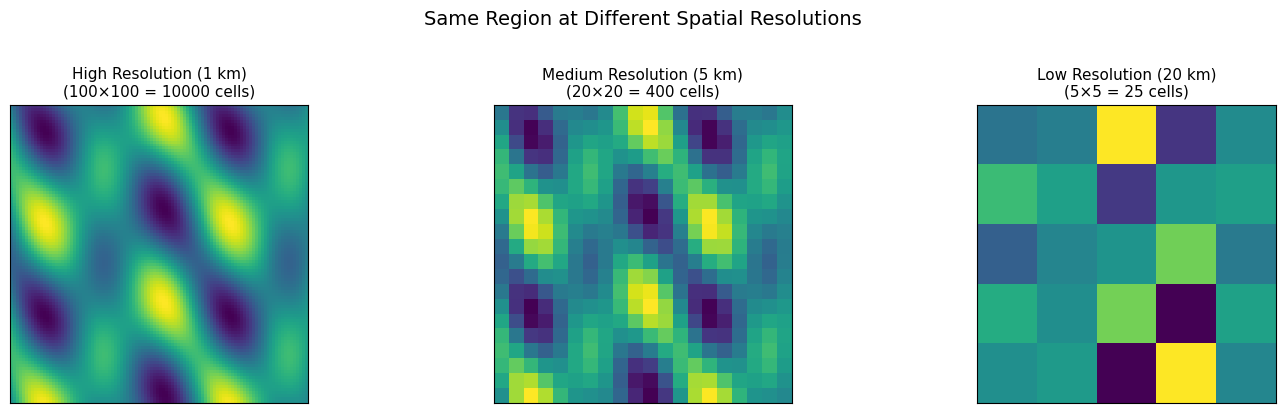

In [5]:
# Visualize resolution differences
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Create a "true" high-resolution field
np.random.seed(123)

resolutions = [100, 20, 5]  # grid cells per side
titles = ['High Resolution (1 km)', 'Medium Resolution (5 km)', 'Low Resolution (20 km)']

for ax, res, title in zip(axes, resolutions, titles):
    x = np.linspace(0, 10, res)
    y = np.linspace(0, 10, res)
    X, Y = np.meshgrid(x, y)
    Z = np.sin(X) * np.cos(Y) + 0.5 * np.sin(2*X + Y)

    ax.pcolormesh(x, y, Z, cmap='viridis', shading='auto')
    ax.set_title(f'{title}\n({res}×{res} = {res**2} cells)', fontsize=11)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle('Same Region at Different Spatial Resolutions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## 2. Coordinate Reference Systems

A **Coordinate Reference System (CRS)** defines how coordinates map to locations on Earth.

### Geographic CRS (Unprojected)

- Uses **latitude** and **longitude** (degrees)
- Based on a 3D model of Earth (ellipsoid)
- Most common: **WGS84** (EPSG:4326) — used by GPS
- Distances and areas are distorted (1° longitude ≠ same distance everywhere)

### Projected CRS

- Transforms 3D Earth to 2D flat surface
- Units typically in meters
- Common examples:
  - **UTM (Universal Transverse Mercator)**: Good for regional analysis
  - **Albers Equal Area**: Preserves area, good for continental maps
  - **Lambert Conformal Conic**: Common for weather maps

### The Problem: Earth is a Sphere, Maps are Flat

Any flat map **distorts** the Earth in some way. Different projections preserve different properties:

| Projection Type | Preserves | Distorts | Use Case |
|-----------------|-----------|----------|----------|
| Conformal | Shapes (angles) | Areas | Navigation, weather maps |
| Equal-area | Areas | Shapes | Thematic maps, density |
| Equidistant | Distances from center | Areas, shapes | Distance measurements |
| Compromise | Nothing perfectly | Everything a little | General reference maps |

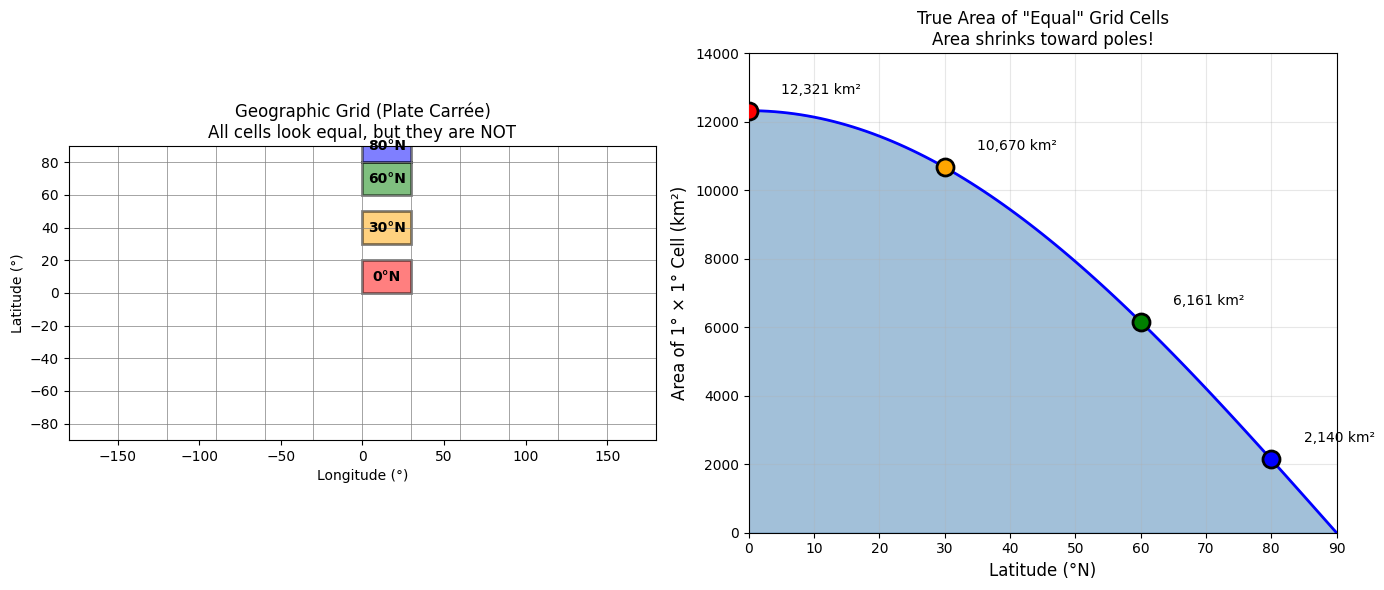

A 1°×1° cell at the equator: ~12,321 km²
A 1°×1° cell at 60°N: ~6,161 km² (half the area!)
A 1°×1° cell at 80°N: ~2,140 km² (only 17%!)


In [6]:
# Visualize how grid cell area varies with latitude in geographic coordinates

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Equal-sized cells in degrees look equal on paper
ax1 = axes[0]
lats = np.arange(-80, 90, 20)
lons = np.arange(-180, 180, 30)

for lat in lats:
    ax1.axhline(lat, color='gray', linewidth=0.5)
for lon in lons:
    ax1.axvline(lon, color='gray', linewidth=0.5)

ax1.set_xlim(-180, 180)
ax1.set_ylim(-90, 90)
ax1.set_xlabel('Longitude (°)')
ax1.set_ylabel('Latitude (°)')
ax1.set_title('Geographic Grid (Plate Carrée)\nAll cells look equal, but they are NOT', fontsize=12)
ax1.set_aspect('equal')

# Highlight cells at different latitudes
from matplotlib.patches import Rectangle
colors = ['red', 'orange', 'green', 'blue']
highlight_lats = [0, 30, 60, 80]
for lat, color in zip(highlight_lats, colors):
    rect = Rectangle((0, lat), 30, 20, fill=True, facecolor=color, alpha=0.5, edgecolor='black', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(15, lat+10, f'{lat}°N', ha='center', va='center', fontsize=10, fontweight='bold')

# Right: Actual area of 1° x 1° cells at different latitudes
ax2 = axes[1]

latitudes = np.arange(0, 91, 1)
cell_area = 111 * 111 * np.cos(np.radians(latitudes))  # km²

ax2.fill_between(latitudes, 0, cell_area, alpha=0.5, color='steelblue')
ax2.plot(latitudes, cell_area, 'b-', linewidth=2)

for lat, color in zip(highlight_lats, colors):
    area = 111 * 111 * np.cos(np.radians(lat))
    ax2.scatter([lat], [area], s=150, c=color, edgecolors='black', linewidth=2, zorder=5)
    ax2.annotate(f'{area:,.0f} km²', (lat, area), xytext=(lat+5, area+500), fontsize=10)

ax2.set_xlabel('Latitude (°N)', fontsize=12)
ax2.set_ylabel('Area of 1° × 1° Cell (km²)', fontsize=12)
ax2.set_title('True Area of "Equal" Grid Cells\nArea shrinks toward poles!', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 14000)

plt.tight_layout()
plt.show()

print(f"A 1°×1° cell at the equator: ~{111*111:,} km²")
print(f"A 1°×1° cell at 60°N: ~{111*111*np.cos(np.radians(60)):,.0f} km² (half the area!)")
print(f"A 1°×1° cell at 80°N: ~{111*111*np.cos(np.radians(80)):,.0f} km² (only 17%!)")

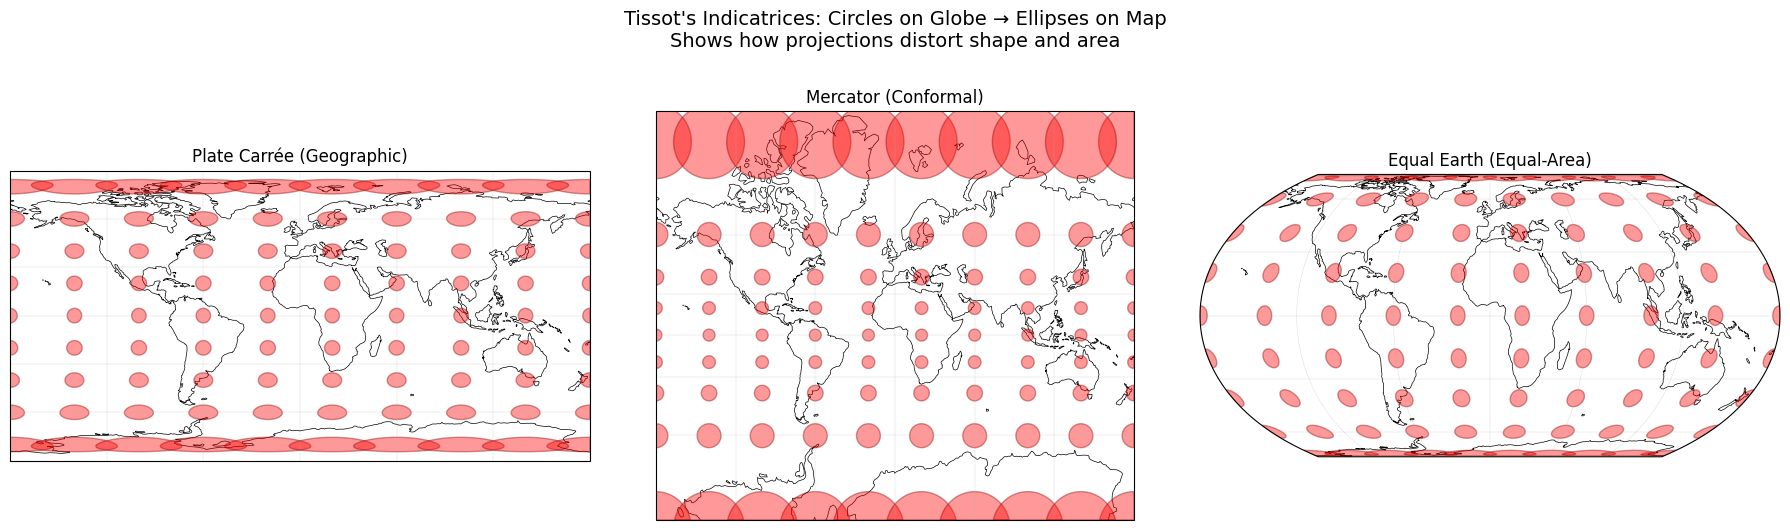

Red circles are the same size on Earth but appear distorted on flat maps:
  - Plate Carrée: Shapes stretch vertically near poles
  - Mercator: Preserves shape but grossly inflates area near poles
  - Equal Earth: Preserves area but distorts shapes


In [7]:
# Visualize projection distortions using Tissot's Indicatrices

import cartopy.crs as ccrs

fig = plt.figure(figsize=(18, 5))

projections = [
    ('Plate Carrée (Geographic)', ccrs.PlateCarree()),
    ('Mercator (Conformal)', ccrs.Mercator()),
    ('Equal Earth (Equal-Area)', ccrs.EqualEarth())
]

for i, (name, proj) in enumerate(projections):
    ax = fig.add_subplot(1, 3, i+1, projection=proj)
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    ax.gridlines(draw_labels=False, linewidth=0.3, alpha=0.5)

    # Draw Tissot's indicatrices (circles that show distortion)
    ax.tissot(rad_km=500, lons=np.arange(-180, 180, 40),
              lats=np.arange(-80, 81, 20), alpha=0.4, facecolor='red', edgecolor='darkred')

    ax.set_title(name, fontsize=12)

plt.suptitle("Tissot's Indicatrices: Circles on Globe → Ellipses on Map\nShows how projections distort shape and area",
             fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

print("Red circles are the same size on Earth but appear distorted on flat maps:")
print("  - Plate Carrée: Shapes stretch vertically near poles")
print("  - Mercator: Preserves shape but grossly inflates area near poles")
print("  - Equal Earth: Preserves area but distorts shapes")

In [8]:
from pyproj import CRS, Transformer

# Define coordinate reference systems
wgs84 = CRS.from_epsg(4326)  # Geographic (lat/lon)
utm16n = CRS.from_epsg(32616)  # UTM Zone 16N (covers Wisconsin)

print("=== WGS84 (Geographic) ===")
print(f"Name: {wgs84.name}")
print(f"Units: {wgs84.axis_info[0].unit_name}")
print(f"Type: {'Geographic' if wgs84.is_geographic else 'Projected'}")

print("\n=== UTM Zone 16N (Projected) ===")
print(f"Name: {utm16n.name}")
print(f"Units: {utm16n.axis_info[0].unit_name}")
print(f"Type: {'Geographic' if utm16n.is_geographic else 'Projected'}")

=== WGS84 (Geographic) ===
Name: WGS 84
Units: degree
Type: Geographic

=== UTM Zone 16N (Projected) ===
Name: WGS 84 / UTM zone 16N
Units: metre
Type: Projected


In [9]:
# Transform coordinates between CRS
transformer = Transformer.from_crs(wgs84, utm16n, always_xy=True)

# Madison, WI coordinates
madison_lon, madison_lat = -89.4012, 43.0731

# Transform to UTM
madison_x, madison_y = transformer.transform(madison_lon, madison_lat)

print("Madison, WI Location:")
print(f"  Geographic (WGS84): {madison_lat:.4f}°N, {abs(madison_lon):.4f}°W")
print(f"  Projected (UTM 16N): {madison_x:.1f} m E, {madison_y:.1f} m N")

Madison, WI Location:
  Geographic (WGS84): 43.0731°N, 89.4012°W
  Projected (UTM 16N): 304510.4 m E, 4771730.9 m N


In [10]:
# Why projections matter: distance calculations
# Distance from Madison to Milwaukee

milwaukee_lon, milwaukee_lat = -87.9065, 43.0389
milwaukee_x, milwaukee_y = transformer.transform(milwaukee_lon, milwaukee_lat)

# In projected coordinates (meters) - accurate
distance_utm = np.sqrt((milwaukee_x - madison_x)**2 + (milwaukee_y - madison_y)**2)

# In geographic coordinates (degrees) - meaningless as distance!
distance_degrees = np.sqrt((milwaukee_lon - madison_lon)**2 + (milwaukee_lat - madison_lat)**2)

print("Distance: Madison → Milwaukee")
print(f"  Using UTM (meters): {distance_utm/1000:.1f} km ✓ (correct)")
print(f"  Using degrees: {distance_degrees:.2f}° ✗ (meaningless as distance)")
print(f"\n  Note: 1° longitude ≈ 111 km at equator, but only ~{111 * np.cos(np.radians(43)):.0f} km at 43°N")

Distance: Madison → Milwaukee
  Using UTM (meters): 121.8 km ✓ (correct)
  Using degrees: 1.50° ✗ (meaningless as distance)

  Note: 1° longitude ≈ 111 km at equator, but only ~81 km at 43°N


### Key Takeaways for CRS

1. **Climate/environmental data usually comes in geographic coordinates (lat/lon)**
2. **Area calculations need weighting** by cos(latitude) or proper projection
3. **When combining datasets**, ensure they use the same CRS
4. **For local analysis**, consider projecting to UTM or local coordinate system

---
## 3. NetCDF Format

### What is NetCDF?

**NetCDF (Network Common Data Form)** is the standard file format for gridded environmental data.

**Key Features:**
- **Self-describing**: Contains metadata explaining what's in the file
- **Multi-dimensional**: Naturally handles lat × lon × time arrays
- **Efficient**: Compressed storage, fast access to subsets
- **Portable**: Works across platforms and programming languages

### NetCDF Structure

Our CRU TS4.09 CONUS file has this structure:

```
NetCDF File
├── Dimensions (define array sizes)
│   ├── time: 1488
│   ├── lat: 50
│   └── lon: 117
├── Variables (the actual data)
│   ├── time(time): datetime values (monthly, mid-month)
│   ├── lat(lat): latitude values (24.75 to 49.25°N)
│   ├── lon(lon): longitude values (-124.75 to -66.75°W)
│   ├── tmp(time, lat, lon): near-surface temperature (°C)
│   ├── stn(time, lat, lon): number of contributing stations
│   ├── mae(time, lat, lon): mean absolute error
│   └── maea(time, lat, lon): MAE anomaly
└── Attributes (metadata)
    ├── title: "CRU TS4.09 Mean Temperature"
    ├── institution: "British Atmospheric Data Centre"
    └── history: "CONUS subset extracted from global file"
```

### CF Conventions

The **Climate and Forecast (CF) conventions** standardize how climate data is described:
- Standard variable names (e.g., `air_temperature`, `precipitation_flux`)
- Units specifications
- Coordinate descriptions

In [11]:
# Load CRU TS4.09 temperature data (CONUS subset, 1901-2024)
# File is in the home directory of Google Drive
cru_path = '/content/drive/MyDrive/cru_ts4.09.1901.2024.tmp.conus.nc'

# Open the dataset
ds = xr.open_dataset(cru_path)

print("CRU Temperature Dataset loaded successfully!")
ds

CRU Temperature Dataset loaded successfully!


<xarray.Dataset> Size: 174MB
Dimensions:  (time: 1488, lat: 50, lon: 117)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
  * lat      (lat) float32 200B 24.75 25.25 25.75 26.25 ... 48.25 48.75 49.25
  * lon      (lon) float32 468B -124.8 -124.2 -123.8 ... -67.75 -67.25 -66.75
Data variables:
    tmp      (time, lat, lon) float32 35MB ...
    stn      (time, lat, lon) float64 70MB ...
    mae      (time, lat, lon) float32 35MB ...
    maea     (time, lat, lon) float32 35MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      CONUS subset (-125.0,24.5)-(-66.5,49.5) extracted from cru_...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

In [12]:
# Check global attributes
print("Global Attributes:")
for attr, value in list(ds.attrs.items())[:10]:  # First 10 attributes
    print(f"  {attr}: {value}")

Global Attributes:
  Conventions: CF-1.4
  title: CRU TS4.09 Mean Temperature
  institution: Data held at British Atmospheric Data Centre, RAL, UK.
  source: Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
  history: CONUS subset (-125.0,24.5)-(-66.5,49.5) extracted from cru_ts4.09.1901.2024.tmp.dat.nc
  references: Information on the data is available at http://badc.nerc.ac.uk/data/cru/
  comment: Access to these data is available to any registered CEDA user.
  contact: support@ceda.ac.uk


In [13]:
# Check the time range
print(f"Time Coverage:")
print(f"  First time step: {pd.to_datetime(ds.time.values[0])}")
print(f"  Last time step: {pd.to_datetime(ds.time.values[-1])}")
print(f"  Total months: {len(ds.time)}")
print(f"  Years covered: {len(ds.time)//12}")

Time Coverage:
  First time step: 1901-01-16 00:00:00
  Last time step: 2024-12-16 00:00:00
  Total months: 1488
  Years covered: 124


---
## 4. Working with xarray

**xarray** extends NumPy arrays with labeled dimensions and coordinates, making it ideal for environmental data.

### DataArray vs Dataset

- **DataArray**: A single variable with labeled coordinates (like `temperature`)
- **Dataset**: A collection of DataArrays sharing the same coordinates (like a NetCDF file)

### Key Advantages

1. **Named dimensions**: Use `dim='time'` instead of `axis=0`
2. **Coordinate-based indexing**: Select by lat/lon values, not array indices
3. **Automatic alignment**: Operations on datasets with different coordinates align automatically
4. **Built-in plotting**: Quick visualization with `.plot()`

> **Note:** Our CRU TS4.09 dataset has 4 variables: `tmp` (temperature), `stn` (station count), `mae` (mean absolute error), and `maea` (MAE anomaly). We'll focus on `tmp`.

In [14]:
# Check the longitude convention in this dataset
print(f"Longitude range in dataset: {float(ds.lon.min()):.1f} to {float(ds.lon.max()):.1f}")

# Determine if we need to adjust for Western Hemisphere
if float(ds.lon.min()) >= 0:
    print("→ Dataset uses 0 to 360 convention")
    print("  To select Western Hemisphere: add 360 to negative longitudes")
    print("  Example: Madison at -89.5° → use 270.5°")
    lon_convention = '0_360'
else:
    print("→ Dataset uses -180 to 180 convention")
    lon_convention = '-180_180'

Longitude range in dataset: -124.8 to -66.8
→ Dataset uses -180 to 180 convention


### 4.1 Selecting Data by Coordinates

In [15]:
# Select by exact coordinate value
# Get temperature at Madison, WI (adjust longitude based on convention)

madison_lat = 43.0
madison_lon = -89.5 if lon_convention == '-180_180' else 360 - 89.5

madison_temp = ds['tmp'].sel(lat=madison_lat, lon=madison_lon, method='nearest')

print(f"Temperature time series at Madison, WI:")
print(f"  Nearest grid point: {float(madison_temp.lat):.2f}°N, {float(madison_temp.lon):.2f}°")
print(f"  Shape: {madison_temp.shape} (one value per month)")
print(f"  First 12 values (1901): {madison_temp.values[:12].round(1)}")

Temperature time series at Madison, WI:
  Nearest grid point: 43.25°N, -89.25°
  Shape: (1488,) (one value per month)
  First 12 values (1901): [ -7.2 -11.6  -1.6   7.8  13.6  20.5  25.6  21.   15.2  10.5   0.2  -7.1]


In [16]:
# Select by coordinate range (slicing)
# Extract Wisconsin region

if lon_convention == '0_360':
    wi_lon_min, wi_lon_max = 360-93, 360-86.5
else:
    wi_lon_min, wi_lon_max = -93, -86.5

wisconsin = ds['tmp'].sel(
    lat=slice(42.5, 47),
    lon=slice(wi_lon_min, wi_lon_max)
)

print(f"Wisconsin subset:")
print(f"  Latitude range: {float(wisconsin.lat.min()):.1f}° to {float(wisconsin.lat.max()):.1f}°")
print(f"  Grid cells: {wisconsin.shape[1]} lat × {wisconsin.shape[2]} lon")
print(f"  Shape: {wisconsin.shape}")

Wisconsin subset:
  Latitude range: 42.8° to 46.8°
  Grid cells: 9 lat × 13 lon
  Shape: (1488, 9, 13)


In [17]:
# Select by time
# Get a single month
jan_2020 = ds['tmp'].sel(time='2020-01')
print(f"January 2020: shape {jan_2020.shape}")

# Get a range of years
recent = ds['tmp'].sel(time=slice('2010', '2024'))
print(f"2010-2024: shape {recent.shape}")

# Get all Julys
all_julys = ds['tmp'].sel(time=ds['tmp'].time.dt.month == 7)
print(f"All July months: shape {all_julys.shape}")

January 2020: shape (1, 50, 117)
2010-2024: shape (180, 50, 117)
All July months: shape (124, 50, 117)


### 4.2 Plotting

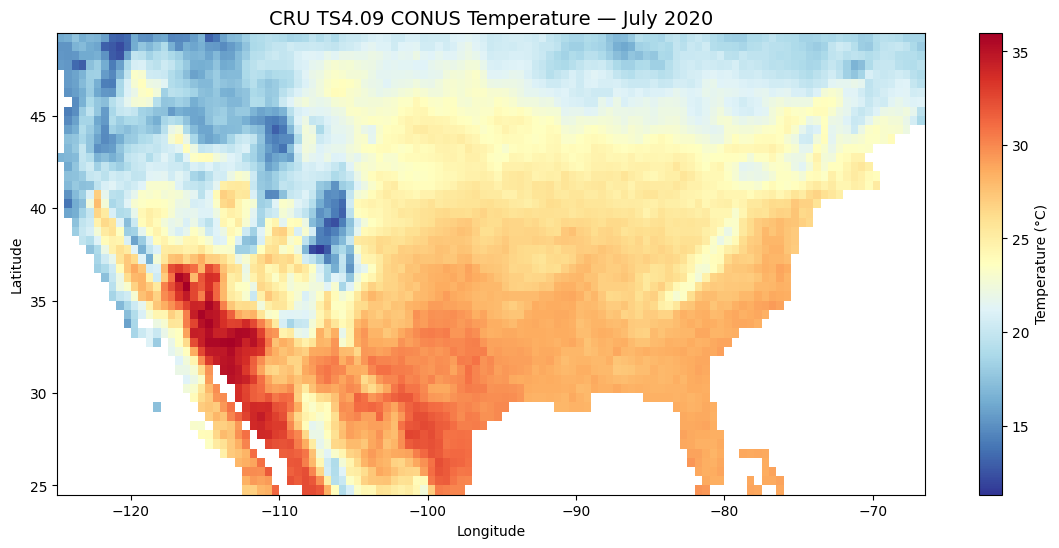

In [18]:
# Plot a single time slice - CONUS temperature
fig, ax = plt.subplots(figsize=(14, 6))

ds['tmp'].sel(time='2020-07').plot(
    ax=ax,
    cmap='RdYlBu_r',
    cbar_kwargs={'label': 'Temperature (°C)'}
)

ax.set_title('CRU TS4.09 CONUS Temperature — July 2020', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

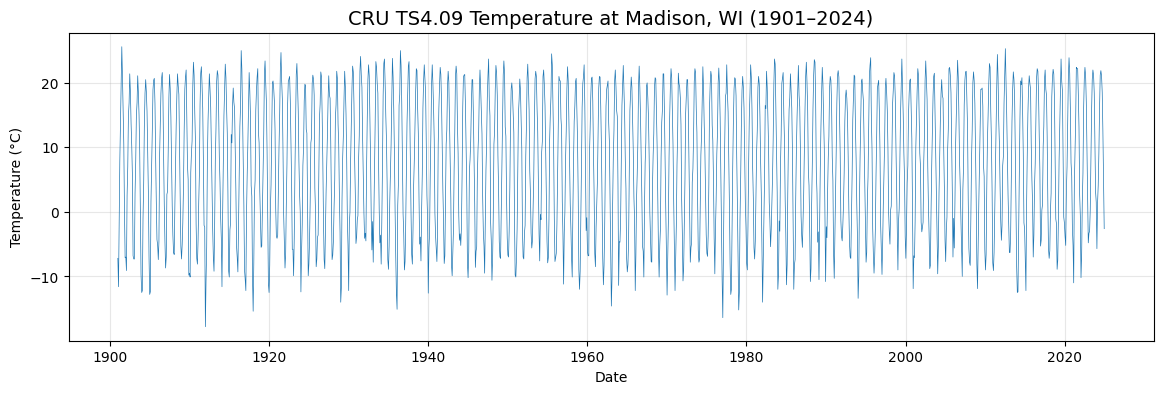

In [19]:
# Plot time series at Madison, WI
fig, ax = plt.subplots(figsize=(14, 4))

madison_temp.plot(ax=ax, linewidth=0.5)

ax.set_title('CRU TS4.09 Temperature at Madison, WI (1901–2024)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.grid(True, alpha=0.3)

plt.show()

### 4.3 Handling Missing Values

CRU data only covers land areas — ocean and coastal water cells are NaN (missing).
In the CONUS subset, this affects coastal ocean areas (Gulf of Mexico, Atlantic, Pacific coasts).

In [20]:
# Check for missing values
sample = ds['tmp'].sel(time='2020-07')
total_cells = sample.size
missing_cells = int(np.isnan(sample.values).sum())
valid_cells = total_cells - missing_cells

print(f"July 2020 data coverage (CONUS bounding box):")
print(f"  Total grid cells: {total_cells:,}")
print(f"  Valid (land) cells: {valid_cells:,} ({100*valid_cells/total_cells:.1f}%)")
print(f"  Missing (ocean/water) cells: {missing_cells:,} ({100*missing_cells/total_cells:.1f}%)")
print(f"  → Ocean/coastal cells within the bounding box have NaN values")

print(f"\nxarray handles NaN automatically in calculations:")
print(f"  CONUS land mean (July 2020): {float(sample.mean()):.2f}°C")

July 2020 data coverage (CONUS bounding box):
  Total grid cells: 5,850
  Valid (land) cells: 4,340 (74.2%)
  Missing (ocean/water) cells: 1,510 (25.8%)
  → Ocean/coastal cells within the bounding box have NaN values

xarray handles NaN automatically in calculations:
  CONUS land mean (July 2020): 24.17°C


---
## 5. Spatial and Temporal Aggregation

### Spatial Averages: Why Area Weighting Matters

As we learned with CRS, grid cells at different latitudes have different areas. A simple mean treats all cells equally — **overweighting** the smaller (northern) cells.

The correction: weight each cell by **cos(latitude)**.

CONUS land mean shape: (1488,) (one value per month)


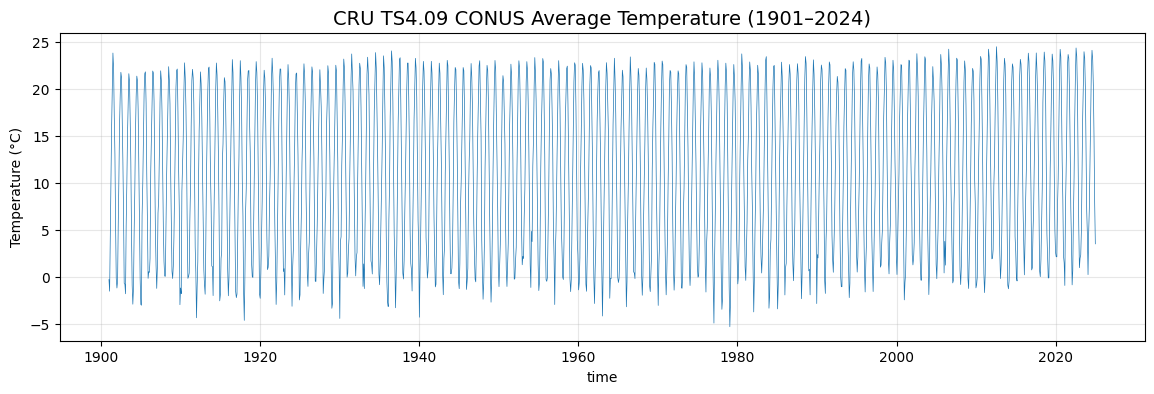

In [21]:
# Simple spatial mean over all CONUS land areas
# This gives one value per time step

conus_mean = ds['tmp'].mean(dim=['lat', 'lon'])
print(f"CONUS land mean shape: {conus_mean.shape} (one value per month)")

fig, ax = plt.subplots(figsize=(14, 4))
conus_mean.plot(ax=ax, linewidth=0.5)
ax.set_title('CRU TS4.09 CONUS Average Temperature (1901–2024)', fontsize=14)
ax.set_ylabel('Temperature (°C)')
ax.grid(True, alpha=0.3)
plt.show()

In [22]:
# The dataset is already a CONUS subset
# (lon: -124.75 to -66.75°W, lat: 24.75 to 49.25°N)
# No further spatial subsetting needed — use the full dataset directly
conus = ds['tmp']
conus_mean = conus.mean(dim=['lat', 'lon'])
print(f"CONUS region shape: {conus.shape}")
print(f"  → {conus.shape[1]} lat cells × {conus.shape[2]} lon cells × {conus.shape[0]} months")

CONUS region shape: (1488, 50, 117)
  → 50 lat cells × 117 lon cells × 1488 months


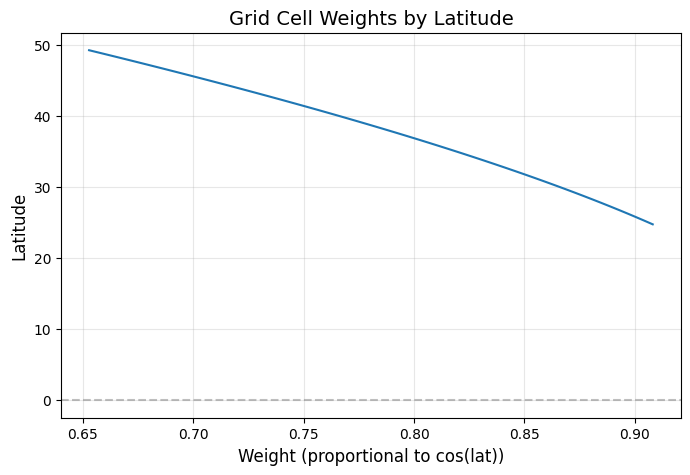

Weight at equator (0°): 1.000
Weight at 45°N: 0.707
Weight at 60°N: 0.500
Weight at 80°N: 0.174


In [23]:
# Calculate weights based on latitude (cosine weighting)
# Area is proportional to cos(latitude)

weights = np.cos(np.deg2rad(ds.lat))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(weights.values, ds.lat.values)
ax.set_xlabel('Weight (proportional to cos(lat))', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Grid Cell Weights by Latitude', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.show()

print(f"Weight at equator (0°): {np.cos(np.deg2rad(0)):.3f}")
print(f"Weight at 45°N: {np.cos(np.deg2rad(45)):.3f}")
print(f"Weight at 60°N: {np.cos(np.deg2rad(60)):.3f}")
print(f"Weight at 80°N: {np.cos(np.deg2rad(80)):.3f}")

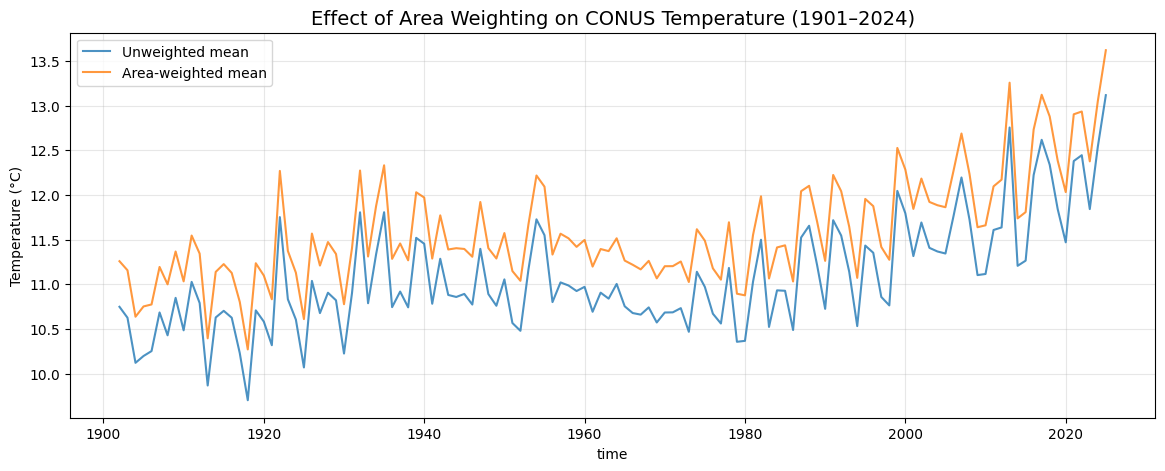

Average difference: -0.52°C
Unweighted mean is biased toward high-latitude (cooler) temperatures
because it over-counts the small northern grid cells.


In [24]:
# Weighted vs unweighted CONUS average

# Unweighted mean (treats all cells equally — INCORRECT)
unweighted_mean = ds['tmp'].mean(dim=['lat', 'lon'])

# Weighted mean (accounts for cell area — CORRECT)
weighted_mean = ds['tmp'].weighted(weights).mean(dim=['lat', 'lon'])

# Compare annual averages
unweighted_annual = unweighted_mean.resample(time='YE').mean()
weighted_annual = weighted_mean.resample(time='YE').mean()

fig, ax = plt.subplots(figsize=(14, 5))
unweighted_annual.plot(ax=ax, label='Unweighted mean', alpha=0.8, linewidth=1.5)
weighted_annual.plot(ax=ax, label='Area-weighted mean', alpha=0.8, linewidth=1.5)

ax.set_title('Effect of Area Weighting on CONUS Temperature (1901–2024)', fontsize=14)
ax.set_ylabel('Temperature (°C)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

diff = float((unweighted_annual - weighted_annual).mean().values)
print(f"Average difference: {diff:.2f}°C")
print("Unweighted mean is biased toward high-latitude (cooler) temperatures")
print("because it over-counts the small northern grid cells.")

### 5.1 Temporal Aggregation

In [25]:
# Resample monthly data to annual means
annual_mean = ds['tmp'].resample(time='YE').mean()

print(f"Original shape (monthly): {ds['tmp'].shape}")
print(f"Annual mean shape: {annual_mean.shape}")
print(f"Years: {int(annual_mean.time.dt.year.values[0])} to {int(annual_mean.time.dt.year.values[-1])}")

Original shape (monthly): (1488, 50, 117)
Annual mean shape: (124, 50, 117)
Years: 1901 to 2024


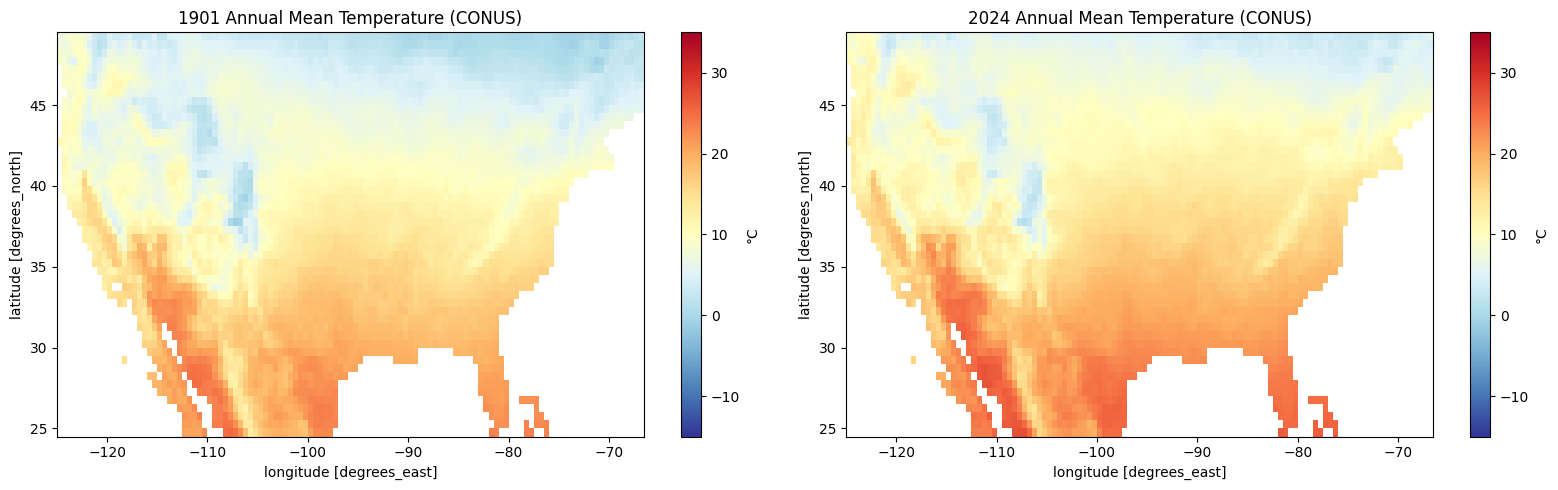

In [26]:
# Compare temperature maps: early period vs recent
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

vmin, vmax = -15, 35

annual_mean.sel(time='1901').plot(ax=axes[0], cmap='RdYlBu_r', vmin=vmin, vmax=vmax,
                                   cbar_kwargs={'label': '°C'})
axes[0].set_title('1901 Annual Mean Temperature (CONUS)')

annual_mean.sel(time='2024').plot(ax=axes[1], cmap='RdYlBu_r', vmin=vmin, vmax=vmax,
                                   cbar_kwargs={'label': '°C'})
axes[1].set_title('2024 Annual Mean Temperature (CONUS)')

plt.tight_layout()
plt.show()

---
## 5.2 Drawing Maps with Cartopy

So far we have used xarray's built-in `.plot()`, which produces quick heatmaps with latitude on the y-axis and longitude on the x-axis. These are fine for exploration, but they:

- Have **no coastlines, borders, or geographic context**
- Use an implicit Plate Carrée projection (which distorts areas at high latitudes)
- Don't look like the professional climate maps you see in publications

**Cartopy** lets us draw proper geographic maps with:
- Coastlines, country & state boundaries
- Choice of map projection
- Gridlines with labels
- Professional cartographic styling

### Recipe

```python
import cartopy.crs as ccrs
import cartopy.feature as cfeature

projection = ccrs.LambertConformal(...)   # choose a projection
fig, ax = plt.subplots(subplot_kw={'projection': projection})
data.plot(ax=ax, transform=ccrs.PlateCarree())  # data is in lat/lon
ax.add_feature(cfeature.STATES)              # add map features
```

The key idea: the **data** lives in PlateCarree (lat/lon), and cartopy **reprojects** it on the fly into whatever projection the axes use.

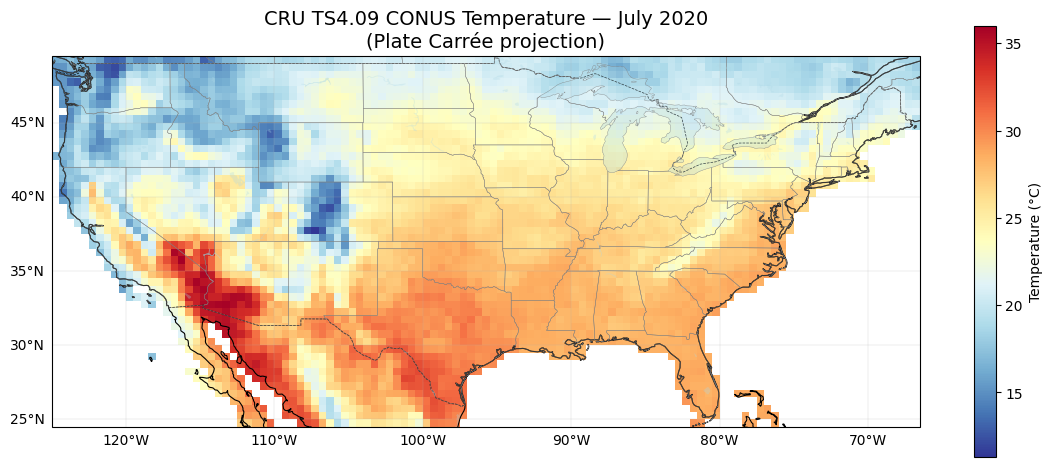

Compare this to the plain xarray .plot() — the coastlines, state
boundaries, and Great Lakes give much better geographic context.


In [29]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Basic map: July 2020 CONUS temperature with geographic features ---
fig, ax = plt.subplots(
    figsize=(14, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Plot the data (transform tells cartopy the data's native CRS)
ds['tmp'].sel(time='2020-07').plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r',
    cbar_kwargs={'label': 'Temperature (°C)', 'shrink': 0.7}
)

# Add geographic features
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--')
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='gray')
ax.add_feature(cfeature.LAKES, alpha=0.3, facecolor='lightblue')

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

ax.set_title('CRU TS4.09 CONUS Temperature — July 2020\n(Plate Carrée projection)', fontsize=14)

plt.show()

print("Compare this to the plain xarray .plot() — the coastlines, state")
print("boundaries, and Great Lakes give much better geographic context.")

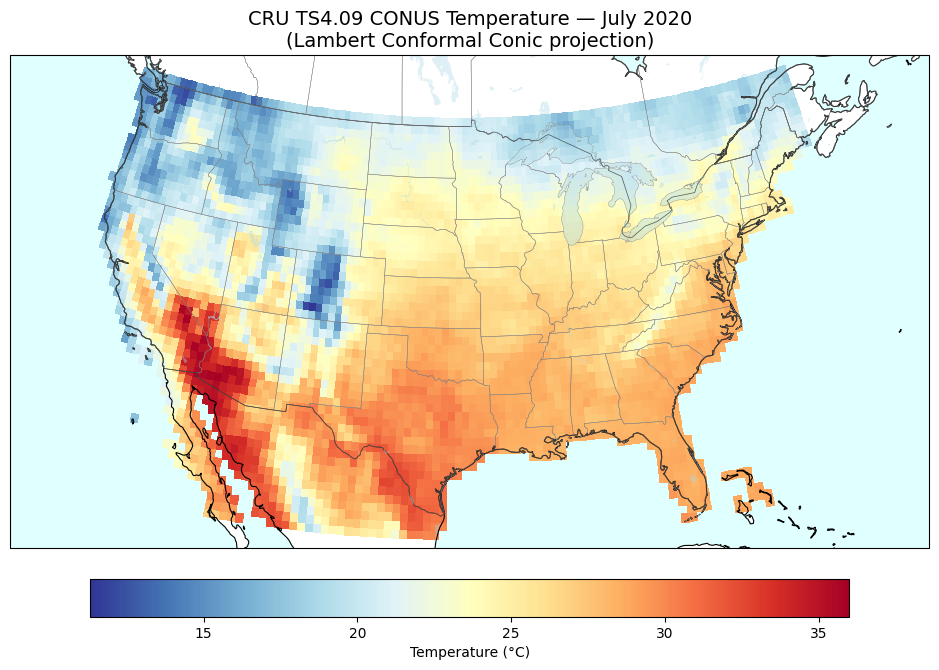

Lambert Conformal Conic is the standard CONUS weather-map projection.
Notice how the grid cells are no longer perfect rectangles — they've
been reprojected so that shapes and areas are more realistic.


In [30]:
# --- Same data, different projection: Lambert Conformal Conic ---
# This is the standard projection for CONUS weather maps (less distortion)

projection = ccrs.LambertConformal(
    central_longitude=-96,   # center of CONUS
    central_latitude=39,
    standard_parallels=(33, 45)
)

fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': projection})

# Set map extent to CONUS
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Plot data
ds['tmp'].sel(time='2020-07').plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r',
    cbar_kwargs={'label': 'Temperature (°C)', 'shrink': 0.7, 'orientation': 'horizontal', 'pad': 0.05}
)

# Map features
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='gray')
ax.add_feature(cfeature.LAKES, alpha=0.4, facecolor='lightblue')
ax.add_feature(cfeature.OCEAN, facecolor='lightcyan')

ax.set_title('CRU TS4.09 CONUS Temperature — July 2020\n(Lambert Conformal Conic projection)', fontsize=14)

plt.show()

print("Lambert Conformal Conic is the standard CONUS weather-map projection.")
print("Notice how the grid cells are no longer perfect rectangles — they've")
print("been reprojected so that shapes and areas are more realistic.")

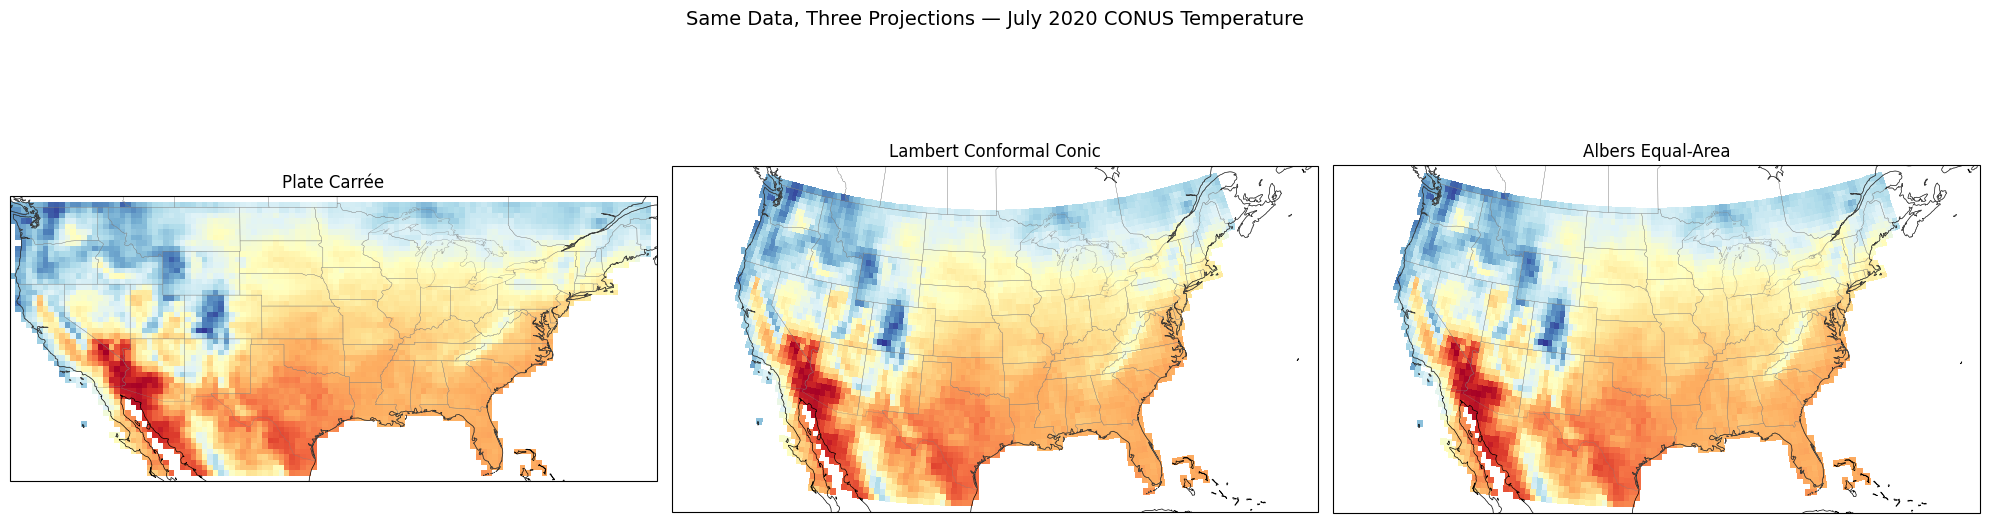

Plate Carrée: simple lat/lon grid, distorts shapes at high latitudes
Lambert Conformal: preserves shapes — standard for weather maps
Albers Equal-Area: preserves area — best for thematic / density maps


In [31]:
# --- Side-by-side: three projections of the same CONUS data ---

jul_2020 = ds['tmp'].sel(time='2020-07')

proj_list = [
    ('Plate Carrée', ccrs.PlateCarree()),
    ('Lambert Conformal Conic', ccrs.LambertConformal(central_longitude=-96, central_latitude=39, standard_parallels=(33, 45))),
    ('Albers Equal-Area', ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=39, standard_parallels=(29.5, 45.5))),
]

fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection': ccrs.PlateCarree()})  # placeholder
# We need to recreate axes with different projections
fig.clear()

for i, (name, proj) in enumerate(proj_list):
    ax = fig.add_subplot(1, 3, i+1, projection=proj)
    ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

    jul_2020.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap='RdYlBu_r', add_colorbar=False
    )

    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.2, edgecolor='gray')
    ax.set_title(name, fontsize=12)

plt.suptitle('Same Data, Three Projections — July 2020 CONUS Temperature',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Plate Carrée: simple lat/lon grid, distorts shapes at high latitudes")
print("Lambert Conformal: preserves shapes — standard for weather maps")
print("Albers Equal-Area: preserves area — best for thematic / density maps")

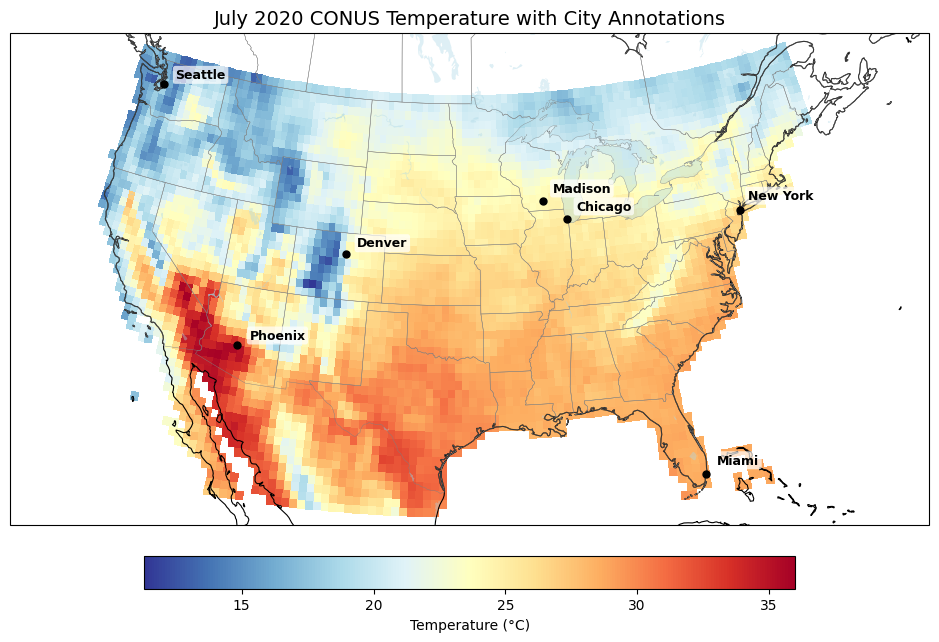

In [32]:
# --- Annotated map: mark specific cities on the temperature field ---

cities = {
    'Madison':      (-89.40, 43.07),
    'Chicago':      (-87.63, 41.88),
    'Denver':       (-104.99, 39.74),
    'Phoenix':      (-112.07, 33.45),
    'Miami':        (-80.19, 25.76),
    'Seattle':      (-122.33, 47.61),
    'New York':     (-74.01, 40.71),
}

projection = ccrs.LambertConformal(
    central_longitude=-96, central_latitude=39, standard_parallels=(33, 45)
)

fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': projection})
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Plot temperature
ds['tmp'].sel(time='2020-07').plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r',
    cbar_kwargs={'label': 'Temperature (°C)', 'shrink': 0.6, 'orientation': 'horizontal', 'pad': 0.05}
)

# Map features
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='gray')
ax.add_feature(cfeature.LAKES, alpha=0.4, facecolor='lightblue')

# Plot cities
for name, (lon, lat) in cities.items():
    ax.plot(lon, lat, 'ko', markersize=5, transform=ccrs.PlateCarree())
    ax.text(lon + 0.8, lat + 0.5, name, fontsize=9, fontweight='bold',
            transform=ccrs.PlateCarree(),
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))

ax.set_title('July 2020 CONUS Temperature with City Annotations', fontsize=14)
plt.show()

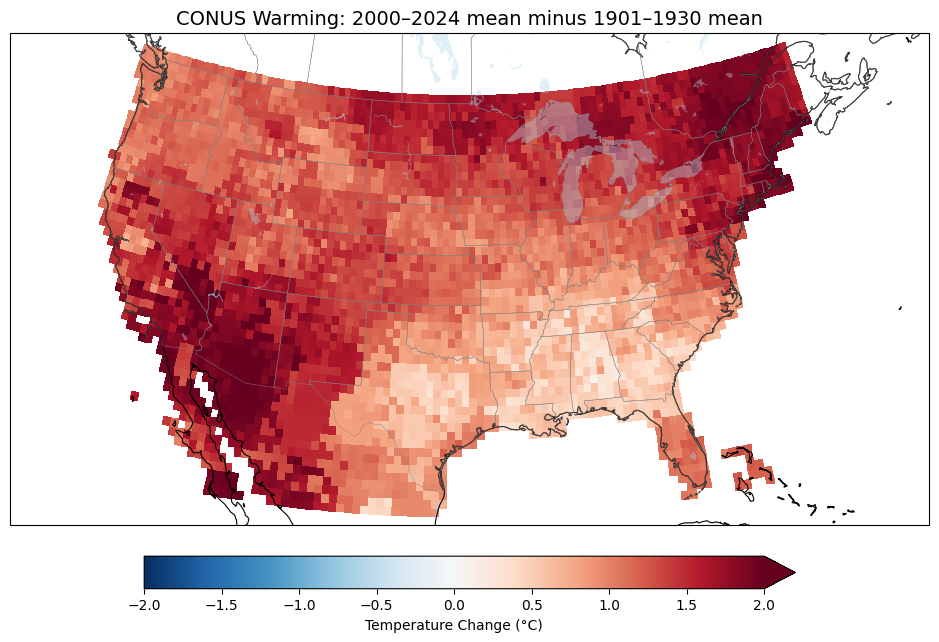

CONUS-wide average warming: 1.27°C
Maximum warming (grid cell): 2.32°C
Red = warmed, Blue = cooled


In [34]:
# --- Map of warming: recent decade minus early 20th century ---

early_period = ds['tmp'].sel(time=slice('1901', '1930')).mean(dim='time')
late_period  = ds['tmp'].sel(time=slice('2000', '2024')).mean(dim='time')
warming = late_period - early_period

projection = ccrs.LambertConformal(
    central_longitude=-96, central_latitude=39, standard_parallels=(33, 45)
)

fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': projection})
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Plot warming
p = warming.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap='RdBu_r', center=0,
    vmin=-2, vmax=2,
    cbar_kwargs={'label': 'Temperature Change (°C)', 'shrink': 0.6,
                 'orientation': 'horizontal', 'pad': 0.05}
)

# Map features
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='gray')
ax.add_feature(cfeature.LAKES, alpha=0.4, facecolor='lightblue')

ax.set_title('CONUS Warming: 2000–2024 mean minus 1901–1930 mean', fontsize=14)
plt.show()

print(f"CONUS-wide average warming: {float(warming.mean()):.2f}°C")
print(f"Maximum warming (grid cell): {float(warming.max()):.2f}°C")
print("Red = warmed, Blue = cooled")

### Cartopy Quick Reference

| Feature | Code |
|---------|------|
| Coastlines | `ax.coastlines()` |
| Country borders | `ax.add_feature(cfeature.BORDERS)` |
| US state boundaries | `ax.add_feature(cfeature.STATES)` |
| Lakes | `ax.add_feature(cfeature.LAKES)` |
| Ocean fill | `ax.add_feature(cfeature.OCEAN)` |
| Land fill | `ax.add_feature(cfeature.LAND)` |
| Gridlines + labels | `ax.gridlines(draw_labels=True)` |
| Set map extent | `ax.set_extent([W, E, S, N], crs=ccrs.PlateCarree())` |

| Projection | Best for |
|------------|----------|
| `ccrs.PlateCarree()` | Quick look, global maps |
| `ccrs.LambertConformal(...)` | CONUS weather maps (preserves shapes) |
| `ccrs.AlbersEqualArea(...)` | Thematic / density maps (preserves area) |
| `ccrs.Mercator()` | Navigation, web maps |
| `ccrs.Orthographic(...)` | Globe view |

**Key rule:** Always pass `transform=ccrs.PlateCarree()` when plotting lat/lon data — this tells cartopy the data's native CRS so it can reproject correctly.

---
## 6. Climate Anomalies

### What is an Anomaly?

A **climate anomaly** is the departure from a reference "normal" period:

$$\text{Anomaly} = \text{Observed} - \text{Climatology}$$

**Climatology:** The long-term average (typically 30 years, e.g., 1991-2020)

### Why Use Anomalies?

1. **Removes seasonal cycle:** Easier to see trends and unusual events
2. **Comparable across locations:** A +2°C anomaly means the same thing in Miami and Minneapolis
3. **Standard in climate science:** Required for comparing observations to climate models

### Standard Reference Periods

- **1991-2020:** Current WMO standard climate normal period
- **1961-1990:** Previous WMO standard
- **1951-1980:** Often used by NASA GISS
- **Pre-industrial (1850-1900):** Used for Paris Agreement targets

In [35]:
# Step 1: Define the baseline/reference period (1991-2020)
baseline = ds['tmp'].sel(time=slice('1991', '2020'))
print(f"Baseline period: 1991-2020")
print(f"  Months in baseline: {len(baseline.time)}")
print(f"  Years: {len(baseline.time)//12}")

Baseline period: 1991-2020
  Months in baseline: 360
  Years: 30


In [36]:
# Step 2: Calculate monthly climatology
# Average January, average February, etc. over the baseline period

climatology = baseline.groupby('time.month').mean(dim='time')
print(f"Climatology shape: {climatology.shape}")
print(f"  → 12 months × {climatology.shape[1]} lat × {climatology.shape[2]} lon")

Climatology shape: (12, 50, 117)
  → 12 months × 50 lat × 117 lon


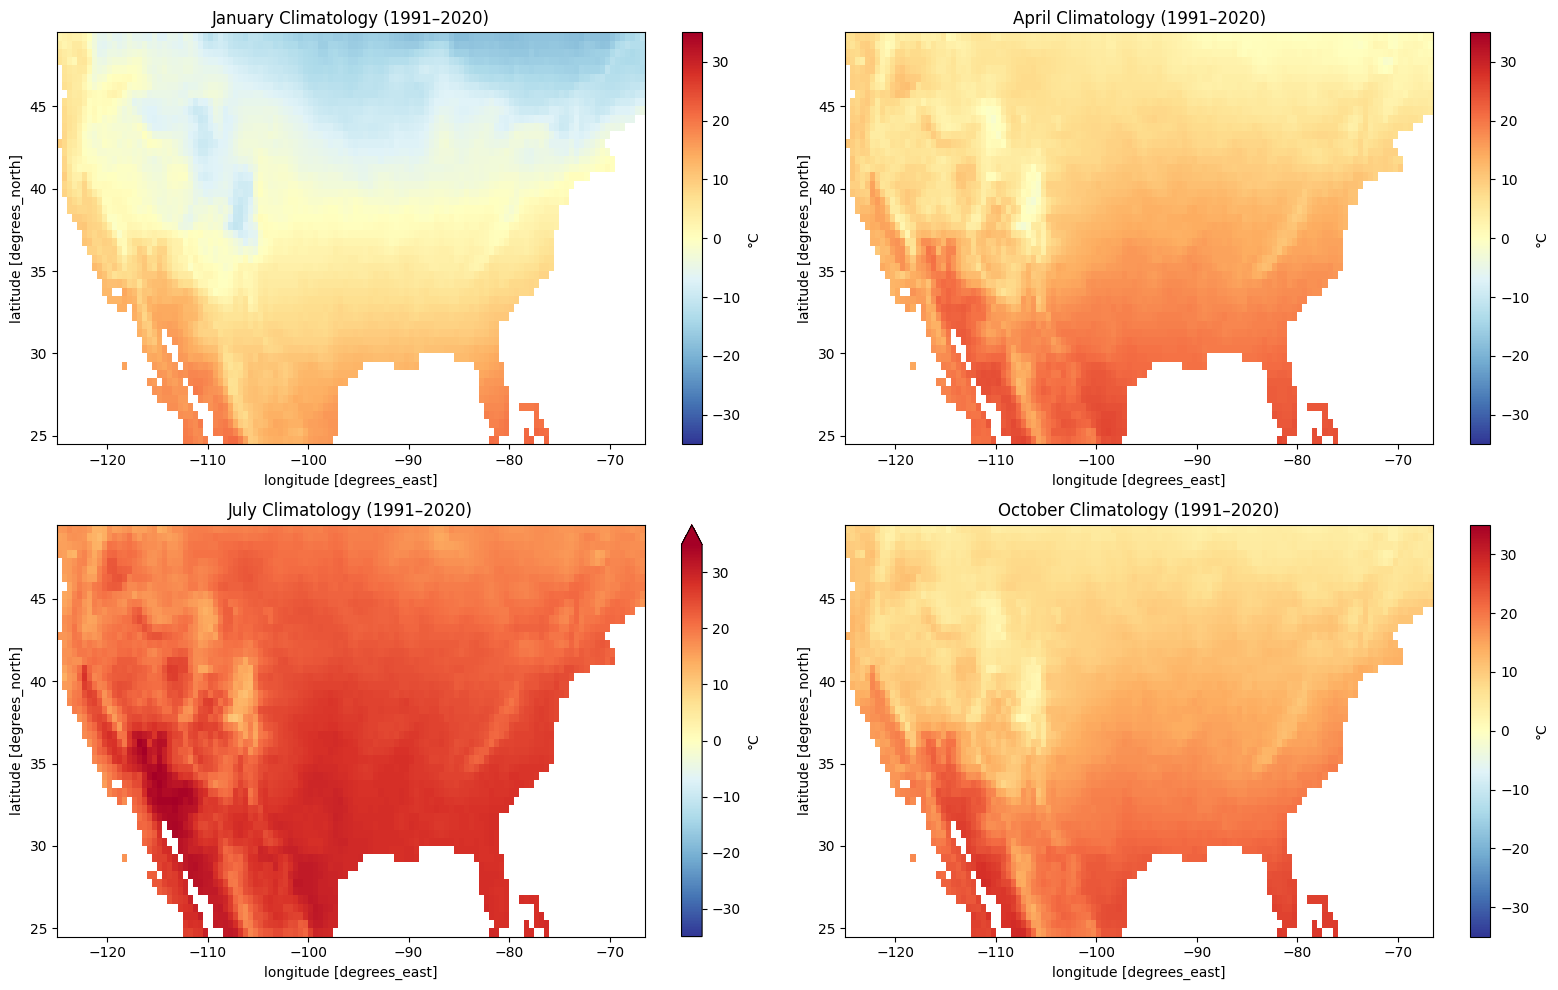

In [37]:
# Visualize the climatology for different months
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

months = [1, 4, 7, 10]
month_names = ['January', 'April', 'July', 'October']

for ax, month, name in zip(axes.flat, months, month_names):
    climatology.sel(month=month).plot(
        ax=ax, cmap='RdYlBu_r',
        vmin=-35, vmax=35,
        cbar_kwargs={'label': '°C'}
    )
    ax.set_title(f'{name} Climatology (1991–2020)', fontsize=12)

plt.tight_layout()
plt.show()

In [38]:
# Step 3: Calculate anomalies
# Subtract the appropriate monthly climatology from each month

anomaly = ds['tmp'].groupby('time.month') - climatology
print(f"Anomaly shape: {anomaly.shape}")
print(f"Anomaly range: {float(anomaly.min()):.1f}°C to {float(anomaly.max()):.1f}°C")

Anomaly shape: (1488, 50, 117)
Anomaly range: -17.2°C to 9.4°C


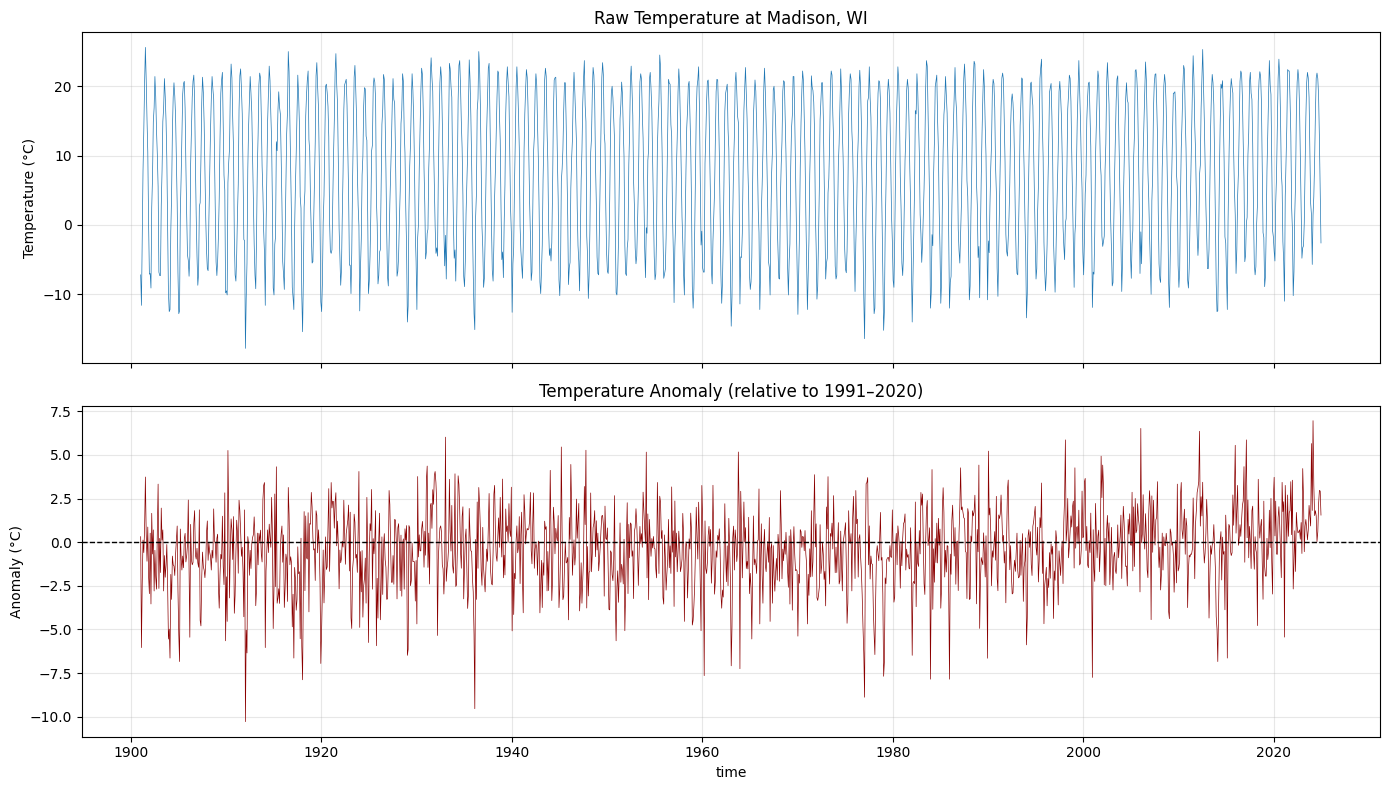

Notice: Anomalies remove the seasonal cycle, making long-term trends visible.


In [39]:
# Compare: raw temperature vs anomaly at Madison, WI
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Get Madison data
madison_raw = ds['tmp'].sel(lat=madison_lat, lon=madison_lon, method='nearest')
madison_anom = anomaly.sel(lat=madison_lat, lon=madison_lon, method='nearest')

# Raw temperature
madison_raw.plot(ax=axes[0], linewidth=0.5)
axes[0].set_title('Raw Temperature at Madison, WI', fontsize=12)
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_xlabel('')
axes[0].grid(True, alpha=0.3)

# Anomaly
madison_anom.plot(ax=axes[1], linewidth=0.5, color='darkred')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Temperature Anomaly (relative to 1991–2020)', fontsize=12)
axes[1].set_ylabel('Anomaly (°C)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice: Anomalies remove the seasonal cycle, making long-term trends visible.")

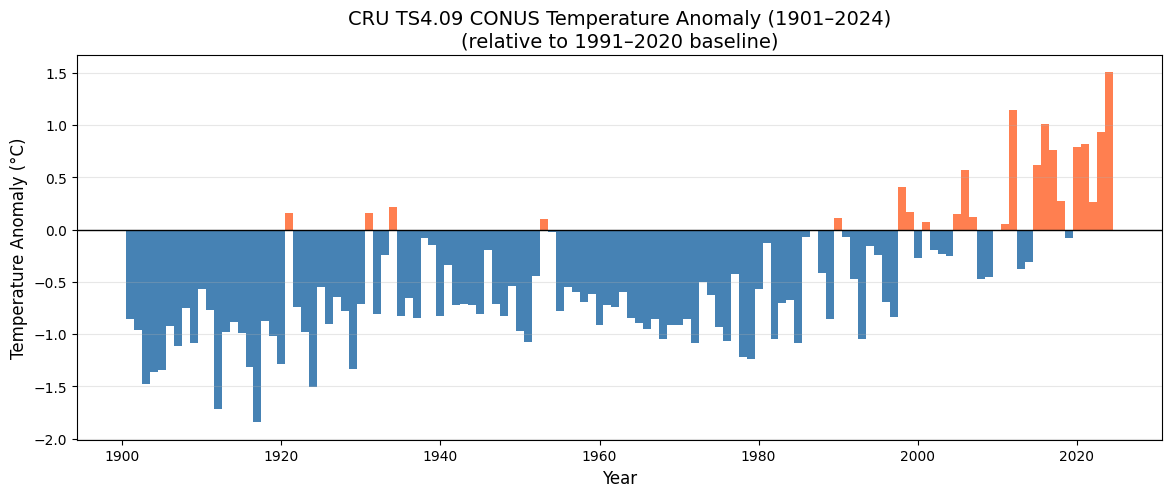

Mean anomaly (1901–1930): -1.00°C
Mean anomaly (2010–2024): 0.49°C
Warming: 1.50°C


In [40]:
# CONUS temperature anomaly (area-weighted)
global_anomaly = anomaly.weighted(weights).mean(dim=['lat', 'lon'])
annual_anomaly = global_anomaly.resample(time='YE').mean()

fig, ax = plt.subplots(figsize=(14, 5))

years = annual_anomaly.time.dt.year.values
values = annual_anomaly.values

colors = ['steelblue' if v < 0 else 'coral' for v in values]
ax.bar(years, values, color=colors, edgecolor='none', width=1)
ax.axhline(0, color='black', linewidth=1)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Temperature Anomaly (°C)', fontsize=12)
ax.set_title('CRU TS4.09 CONUS Temperature Anomaly (1901–2024)\n(relative to 1991–2020 baseline)', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

plt.show()

# Calculate warming over the full record
early = float(annual_anomaly.sel(time=slice('1901', '1930')).mean().values)
late = float(annual_anomaly.sel(time=slice('2010', '2024')).mean().values)
print(f"Mean anomaly (1901–1930): {early:.2f}°C")
print(f"Mean anomaly (2010–2024): {late:.2f}°C")
print(f"Warming: {late - early:.2f}°C")

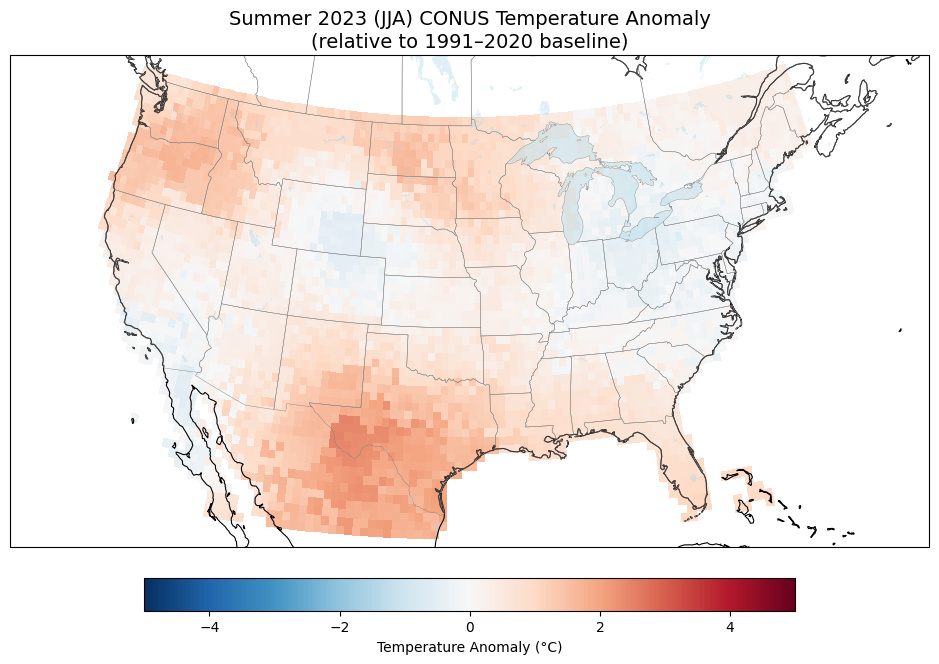

In [41]:
# Map: Summer 2023 temperature anomaly (JJA) — now with cartopy!
summer_2023_anom = anomaly.sel(time=slice("2023-06", "2023-08")).mean(dim="time")

projection = ccrs.LambertConformal(
    central_longitude=-96, central_latitude=39, standard_parallels=(33, 45)
)

fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={"projection": projection})
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

summer_2023_anom.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    center=0,
    vmin=-5, vmax=5,
    cbar_kwargs={"label": "Temperature Anomaly (°C)", "shrink": 0.6,
                 "orientation": "horizontal", "pad": 0.05}
)

ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="gray")
ax.add_feature(cfeature.LAKES, alpha=0.4, facecolor="lightblue")

ax.set_title("Summer 2023 (JJA) CONUS Temperature Anomaly\n(relative to 1991–2020 baseline)", fontsize=14)
plt.show()


---
## Exercise

**Task:** Analyze the Great Lakes region winter 2021–2022 temperature anomaly.

1. Extract the Great Lakes region (lat: 41–49°N, lon: −93 to −75°W) from the anomaly data
2. Select winter 2021–2022 months (Dec 2021, Jan 2022, Feb 2022)
3. Calculate the area-weighted mean anomaly for that region and season
4. Report whether the winter was warmer or colder than normal

In [ ]:
# Your code here



---
## Summary

### Key Concepts

| Concept | Description |
|---------|-------------|
| Gridded Data | Continuous environmental fields on regular lat/lon/time grids |
| CRS | Coordinate Reference Systems define how coordinates map to Earth; projections cause distortion |
| NetCDF | Self-describing file format standard for climate/environmental data |
| xarray | Python library for labeled multi-dimensional arrays |
| Area Weighting | Must weight by cos(latitude) for accurate spatial averages |
| Cartopy | Library for drawing publication-quality maps with coastlines, borders, and projections |
| Climatology | Long-term average (typically 30 years) for each month/season |
| Anomaly | Departure from climatology: Observed − Normal |

### Key xarray Operations

| Task | Method |
|------|--------|
| Load NetCDF | `xr.open_dataset("file.nc")` |
| Select by value | `.sel(lat=43, lon=-89)` |
| Select nearest | `.sel(lat=43, method="nearest")` |
| Slice range | `.sel(lat=slice(40, 50))` |
| Mean over dimension | `.mean(dim="time")` or `.mean(dim=["lat", "lon"])` |
| Weighted mean | `.weighted(weights).mean(dim=...)` |
| Resample time | `.resample(time="YE").mean()` |
| Group by month | `.groupby("time.month")` |

### Key Cartopy Operations

| Task | Code |
|------|------|
| Create map axes | `plt.subplots(subplot_kw={"projection": ccrs.LambertConformal(...)})` |
| Plot lat/lon data | `data.plot(ax=ax, transform=ccrs.PlateCarree())` |
| Add coastlines | `ax.coastlines()` |
| Add state borders | `ax.add_feature(cfeature.STATES)` |
| Set map extent | `ax.set_extent([W, E, S, N], crs=ccrs.PlateCarree())` |
| Add gridlines | `ax.gridlines(draw_labels=True)` |

### Next Lecture

**Lecture 12:** Satellite Remote Sensing & Raster Analysis — working with Landsat/Sentinel imagery, spectral indices, and land cover analysis.

---
## Solution

In [42]:
# Exercise Solution

# 1. Extract Great Lakes region (adjust longitude for convention)
if lon_convention == '0_360':
    great_lakes = anomaly.sel(
        lat=slice(41, 49),
        lon=slice(360-93, 360-75)
    )
else:
    great_lakes = anomaly.sel(
        lat=slice(41, 49),
        lon=slice(-93, -75)
    )
print(f"Great Lakes region shape: {great_lakes.shape}")

# 2. Select winter 2021-2022 (Dec 2021, Jan 2022, Feb 2022)
winter_months = great_lakes.sel(time=slice('2021-12', '2022-02'))
print(f"Winter months selected: {winter_months.time.values}")

# 3. Calculate area-weighted mean
gl_weights = np.cos(np.deg2rad(great_lakes.lat))
winter_mean = winter_months.weighted(gl_weights).mean(dim=['lat', 'lon', 'time'])

# 4. Report
anomaly_value = float(winter_mean)
print(f"\nWinter 2021-2022 Great Lakes Temperature Anomaly: {anomaly_value:+.2f}°C")

if anomaly_value > 0:
    print(f"→ Winter 2021-2022 was {abs(anomaly_value):.2f}°C WARMER than the 1991-2020 average.")
else:
    print(f"→ Winter 2021-2022 was {abs(anomaly_value):.2f}°C COLDER than the 1991-2020 average.")

Great Lakes region shape: (1488, 16, 36)
Winter months selected: ['2021-12-16T00:00:00.000000000' '2022-01-16T00:00:00.000000000'
 '2022-02-15T00:00:00.000000000']

Winter 2021-2022 Great Lakes Temperature Anomaly: -0.19°C
→ Winter 2021-2022 was 0.19°C COLDER than the 1991-2020 average.
